# Micro Sim Controllable Model

## Imports

In [1]:
import os
import time
import gc
from itertools import chain
import json
import pickle
import numpy as np
from tqdm import tqdm
from dataclasses import dataclass, asdict
from typing import Tuple

from PIL import Image
from IPython import display
from IPython.display import Video
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
import cv2
import moviepy.editor as mpy
from base64 import b64encode

import torch
from torch import nn
from torchvision.utils import make_grid
from torchvision.transforms import Normalize
from torchvision.transforms.functional import to_tensor, to_pil_image, center_crop
from kornia.geometry.transform import resize, warp_affine, get_affine_matrix2d
import kornia

from diffusers import UNet2DModel, DDIMScheduler, get_cosine_schedule_with_warmup

import wandb

In [2]:
wandb.login()

wandb: Currently logged in as: parameterized. Use `wandb login --relogin` to force relogin


True

## Data and model configuration

In [3]:
@dataclass
class Config:
    # data
    dataset_path: str = 'datasets/jams-germs/buttercup-dataset.pkl'
    dataset_vid_path: str = 'datasets/jams-germs/raw-videos/Buttercup the Water Bear Sees a Giant Amoeba-H3jCiKa6BS8.mkv'
    device: str = 'cuda'
    
    # model
    model_id: str = None
    model_type: str = 'controllable'
    num_memory_x: int = 8
    num_memory_h: int = 4
    sample_size: int = 64
    img_shape: Tuple[int] = None
    # resolution before zooming in
    img_full_shape: Tuple[int] = None
    layers_per_block = 2
    block_out_channels: Tuple[int] = (32, 32, 64, 128, 128)
    down_block_types: Tuple[str] = (
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    )
    up_block_types: Tuple[str] = (
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
    
    # training
    load_pretrained: bool = False
    pretrained_path: str = 'models/VideoUNet_284608451'
    pool_size: int = 64
    pool_replace_rate: float = 1 / 4
    batch_size: int = 16
    num_batch_frames: int = 4
    num_training_steps: int = int(5e4)
    lr: float = 1e-4
    num_warmup_steps: int = int(1e3)
    
    # training visualization/saving
    loss_every_n: int = 10
    display_every_n: int = 50
    video_every_n: int = int(2e3)
    save_every_n: int = int(1e3)
    
    # noise scheduler
    noise_scheduler_type: str = 'DDIM'
    num_train_timesteps: int = 1000
    # corresponds to first n of train timesteps
    num_memory_timesteps: int = 50
    # try to make differences (and last value) divide num_train_timesteps
    # start with small steps to reduce random color tinting
    # end with small steps to better reduce noise
    inference_timesteps: Tuple[int] = (
        999, 990, 980, 970, 950, 900, 800, 600, 400, 200, 100, 50, 20, 10, 0
    )
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # automatically set these
        self.img_shape = (3, self.sample_size, self.sample_size)
        self.img_full_shape = (3, self.sample_size * 2, self.sample_size * 2)

cf = Config()
asdict(cf)

{'dataset_path': 'datasets/jams-germs/buttercup-dataset.pkl',
 'dataset_vid_path': 'datasets/jams-germs/raw-videos/Buttercup the Water Bear Sees a Giant Amoeba-H3jCiKa6BS8.mkv',
 'device': 'cuda',
 'model_id': None,
 'model_type': 'controllable',
 'num_memory_x': 8,
 'num_memory_h': 4,
 'sample_size': 64,
 'img_shape': (3, 64, 64),
 'img_full_shape': (3, 128, 128),
 'block_out_channels': (32, 32, 64, 128, 128),
 'down_block_types': ('DownBlock2D',
  'DownBlock2D',
  'DownBlock2D',
  'AttnDownBlock2D',
  'DownBlock2D'),
 'up_block_types': ('UpBlock2D',
  'AttnUpBlock2D',
  'UpBlock2D',
  'UpBlock2D',
  'UpBlock2D'),
 'load_pretrained': False,
 'pretrained_path': 'models/VideoUNet_284608451',
 'pool_size': 64,
 'pool_replace_rate': 0.25,
 'batch_size': 16,
 'num_batch_frames': 4,
 'num_training_steps': 50000,
 'lr': 0.0001,
 'num_warmup_steps': 1000,
 'loss_every_n': 10,
 'display_every_n': 50,
 'video_every_n': 2000,
 'save_every_n': 1000,
 'noise_scheduler_type': 'DDIM',
 'num_train_ti

## Display setup

In [4]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['image.cmap'] = 'binary'
sns.set_theme(style='darkgrid')

def display_video(path, loop=True):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display.display(display.HTML(f'''<video src="{
        data_url}" controls=true autoplay=true {
        "loop=true " if loop else ""}/>'''))

## Data processing

In [5]:
class Dataset():
    def __init__(self, imgs, embs, track):
        self.imgs = imgs
        self.embs = embs
        self.track = track
        
        self.mean = imgs.mean(dim=(0, 2, 3))
        # self.std = imgs.std(dim=(0, 2, 3))
        # actual std is around .1 but this works much better
        self.std = torch.full((3,), .5)
        self.frame_count = imgs.shape[0]
        
        self.norm = Normalize(self.mean, self.std)
        self.denorm = Normalize(-self.mean / self.std, 1 / self.std)
        
        self.imgs = self.norm(self.imgs)
    
    def sample(self, start_frames, num_frames=None):
        """
        Sample dataset at given start frames
        Returns: [imgs, embs, track]
        """
        if num_frames is None:
            num_frames = cf.num_batch_frames
        frames = [
            [
                getattr(self, prop)[start_frames + i].to(cf.device).clone()
                for i in range(num_frames)
            ] for prop in ['imgs', 'embs', 'track']
        ]
        return [torch.stack(v, dim=1) for v in frames]
    
    def tensor_to_img(self, x):
        return Image.fromarray(
            self.denorm(x).clip(0, 1).movedim(-3, -1).detach().cpu()
            .multiply(255).type(torch.uint8).numpy()
        )

In [6]:
def process_dataset():
    # load tracking (generated from 910x512 frames)
    with open('datasets/track-buttercup.json', 'r') as f:
        track_json = json.load(f)
        # body (x, y normalized so [0, 1] is sample bounds),
        # head direction (angle in radians),
        # and cam pos (x, y same scale as body, total offst from first frame)
        body = torch.tensor(track_json['body'])
        track = torch.empty(body.shape[0], 5)
        head = torch.tensor(track_json['head'])
        head_offset = head - body
        track[:, :2] = (body - torch.tensor([[199, 0]])) / 512
        track[:, 2] = torch.atan2(head_offset[:, 1], head_offset[:, 0])

        world = (torch.tensor(track_json['world']) - torch.tensor([[199, 0]])) / 512
        world_diff = torch.cat([torch.tensor([[0, 0]]), world.diff(dim=0)], dim=0)
        for jump in track_json['jumps']:
            if jump > 0:
                world_diff[jump] = world_diff[jump - 1]

        track[:, 3:5] = -world_diff.cumsum(dim=0)
    
    cap = cv2.VideoCapture(cf.dataset_vid_path)
    vid_w, vid_h = (
        cap.get(cv2.CAP_PROP_FRAME_WIDTH),
        cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    )
    ci, cj = torch.meshgrid(
        *[torch.arange(cf.sample_size * 2) for _ in range(2)], 
        indexing='xy'
    )
    coords = torch.stack([ci, cj], dim=0)
    # storing all takes about 3.3 GB
    imgs = []
    embs = []
    
    for i in tqdm(range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1)):        
        success, img = cap.read()
        if not success or i == 100:
            print(f'failed on {i}')
            break
        
        # crop and resize image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = to_tensor(img)
        # try to center subject in frame before cropping
        max_track = (vid_w - vid_h) // 2
        track_body_x = ((track[i, 0] - .5) * vid_h).clip(-max_track, max_track).item()
        affine_mat = get_affine_matrix2d(
            translations=torch.tensor([[round(-track_body_x), 0]]),
            center=torch.zeros(1, 2), scale=torch.ones(1, 2),
            angle=torch.zeros(1))[:, :2]
        img = warp_affine(img[None], affine_mat, img.shape[-2:])[0]
        tbx_normed = round(track_body_x) / vid_h
        track[i, 0] -= tbx_normed # body
        track[i, 3] += tbx_normed # cam
        img = center_crop(img, vid_h)
        img = to_pil_image(img)
        # will train on random crops up to 2x scale
        img.thumbnail((cf.sample_size * 2,) * 2, Image.LANCZOS)
        imgs.append(to_tensor(img))
        
        # generate localizing embedding image
        # body -> pixel
        dirs = coords - track[i, :2, None, None] * (cf.sample_size * 2)
        angles = torch.atan2(dirs[1], dirs[0])
        angles = angles - track[i, 2]
        local_dx = angles.cos()
        local_dy = angles.sin()
        dist = (dirs[0]**2 + dirs[1]**2).sqrt() * (2 / cf.sample_size)
        local_embedding = torch.stack([
            local_dx, local_dy, 1 - dist
        ], dim=0)
        embs.append(local_embedding)
    
    imgs = torch.stack(imgs)
    embs = torch.stack(embs)
    return Dataset(imgs, embs, track)


if os.path.exists(cf.dataset_path):
    print('Dataset already processed')
    with open(cf.dataset_path, 'rb') as f:
        dataset = pickle.load(f)
    print('Loaded dataset')
else:
    print('Processing dataset...')
    dataset = process_dataset()
    with open(cf.dataset_path, 'wb') as f:
        pickle.dump(dataset, f)
    print('Saved dataset')

Dataset already processed
Loaded dataset


## Data sampling utilities

In [7]:
class Pool():
    def __init__(self, size=cf.pool_size, batch_size=cf.batch_size):
        """Create pool using cf config"""
        self.size = size
        self.batch_size = batch_size
        
        self.batch_frame_id = torch.empty(self.size, dtype=torch.long, device=cf.device)
        self.is_first = torch.empty(self.size, dtype=torch.bool)
        self.first_campos = torch.empty(self.size, 2, device=cf.device)
        self.cam_offsets = torch.empty(self.size, 2, device=cf.device)
        
        self.first_frame_rgb = torch.empty(
            self.size, *cf.img_full_shape, device=cf.device)
        self.first_frame_emb = torch.empty_like(self.first_frame_rgb)
        self.memory = torch.empty(
            self.size, cf.num_memory_h, *cf.img_shape[1:], device=cf.device)
        
        self.crop_size = round(cf.sample_size * 1.5)
        self.resize_crop = lambda x: resize(center_crop(
            x, self.crop_size), cf.sample_size)
        
        self.init()
    
    def init(self, indices=None):
        """Re-initialize entire pool or at given indices"""
        if indices is None:
            indices = torch.arange(self.size)
        if len(indices) == 0:
            return
        
        # low=1 so prev frame is valid
        self.batch_frame_id[indices] = torch.randint(1,
            dataset.frame_count - cf.num_batch_frames + 1,
            size=(len(indices),), device=cf.device)
        
        rgb, emb, track = dataset.sample(self.batch_frame_id[indices], num_frames=1)
        
        self.is_first[indices] = True
        self.first_campos[indices] = track[:, 0, -2:]
        # try to center vertically
        first_ypos = track[:, 0, 1] - .5
        # center cropping to 3/4 -> can offset up to 1/8 any dir
        self.cam_offsets[indices] = (
            torch.rand(len(indices), 2, device=cf.device) * 2 - 1) / 8
        self.cam_offsets[indices, 1] -= first_ypos
        self.cam_offsets[indices, 1] = self.cam_offsets[indices, 1].clip(-1 / 8, 1 / 8)
        self.cam_offsets[indices] *= cf.sample_size * 2
        
        self.first_frame_rgb[indices] = rgb[:, 0]
        self.first_frame_emb[indices] = emb[:, 0]
        self.memory[indices] = torch.randn(
            len(indices), cf.num_memory_h, *cf.img_shape[1:], device=cf.device)
    
    def sample(self, indices=None, show_stabilization=False):
        """
        Sample pool at given indices
        First frame of imgs and embs will be previous frame
        First image will be randn for new sequences
        Args:
            indices: pool indices to sample
            show_stabilization: darken areas where the sequence's
                first frame is used for stabilization
        Returns: imgs, embs, memory
        """
        
        # replace front of batch with new samples
        self.init(indices[:round(len(indices) * cf.pool_replace_rate)])
        
        imgs, embs, track = dataset.sample(self.batch_frame_id[indices] - 1,
            num_frames=cf.num_batch_frames + 1)
        
        imgs[self.is_first[indices], 0] = torch.randn_like(
            imgs[self.is_first[indices], 0])
        
        # todo: center vertically
        cm = ((track[:, :, -2:] - self.first_campos[indices, None])
              * (cf.sample_size * 2) + self.cam_offsets[indices, None]).round()
        cm = cm.view(-1, cm.shape[-1])
        affine_mat = get_affine_matrix2d(
            translations=cm, center=torch.zeros_like(cm),
            scale=torch.ones_like(cm), angle=torch.zeros_like(cm[:, 0]))[..., :2, :]
        stabilize = lambda x: warp_affine(
            x.view(-1, *x.shape[-3:]), affine_mat, x.shape[-2:]).view(x.shape)
        
        imgs = stabilize(imgs)
        embs = stabilize(embs)
        mask = stabilize(torch.ones_like(imgs))
        first_offset = -.5 if show_stabilization else 0
        imgs = imgs + (1 - mask) * (self.first_frame_rgb[indices, None] + first_offset)
        embs = embs + (1 - mask) * (self.first_frame_emb[indices, None] + first_offset)
        
        # todo: center vertically
        imgs = self.resize_crop(imgs)
        embs = self.resize_crop(embs)
        
        return imgs, embs, self.memory[indices]
    
    def replace(self, indices, memory):
        """
        Replace memory at indices and update batch_frame_id and is_first
        Re-initializes sequences that reach the video end or have too much cam movement
        """
        self.memory[indices] = memory
        self.batch_frame_id[indices] += cf.num_batch_frames
        self.is_first[indices] = False
        
        # re-init if end reached
        re_init_end = self.batch_frame_id[indices] \
            >= dataset.frame_count - cf.num_batch_frames * 2
        self.init(indices[re_init_end])
        rem_indices = indices[~re_init_end]
        # re-init if significant cam movement
        imgs, embs, track = dataset.sample(
            self.batch_frame_id[rem_indices] + cf.num_batch_frames - 1, num_frames=1)
        cm = ((track[:, :, -2:] - self.first_campos[rem_indices, None])
              * (cf.sample_size * 2) + self.cam_offsets[rem_indices, None])
        re_init_cam = (cm.abs() > (cf.sample_size / 4)).any(dim=-1)[:, 0]
        self.init(rem_indices[re_init_cam])

## Visualize data sampling

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  9.70it/s]


Moviepy - Building video output/train_set_buttercup.mp4.
Moviepy - Writing video output/train_set_buttercup.mp4



Moviepy - Done !
Moviepy - video ready output/train_set_buttercup.mp4


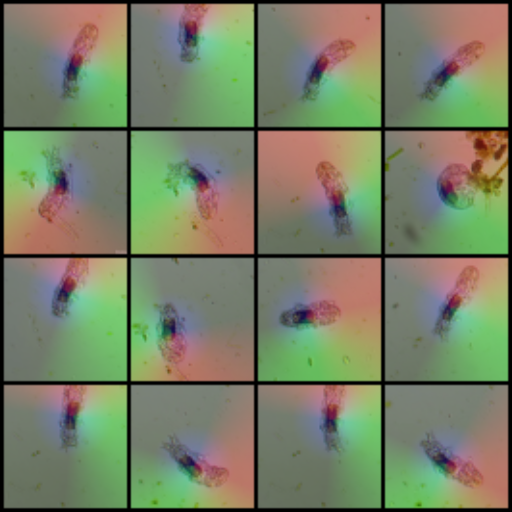

In [8]:
def gen_trainset_video(path, fps=25):
    tqdm._instances.clear()
    tp = Pool(size=16)
    perm = torch.arange(16)
    full_imgs = torch.empty(16, 4 * 40, *cf.img_shape, device=cf.device)
    full_embs = torch.empty_like(full_imgs, device=cf.device)
    for i in tqdm(range(full_imgs.shape[1] // 4)):
        # first 1/4 get replaced with new samples
        imgs, embs, memory = tp.sample(perm, show_stabilization=True)
        full_imgs[:, 4 * i:4 * (i + 1)] = imgs[:, 1:]
        full_embs[:, 4 * i:4 * (i + 1)] = embs[:, 1:]
        tp.replace(perm, memory)
    
    full_imgs = dataset.denorm(full_imgs)
    
    def make_frame(frame_state):
        if frame_state['first_frame']:
            frame_state['first_frame'] = False
            return np.zeros((512, 512, 3), dtype=np.int8)
        
        i = frame_state['i']
        frame = .7 * full_imgs[:, i] + .3 * full_embs[:, i].clip(0, 1)
        
        frame = make_grid(frame, nrow=4)
        frame_state['i'] = min(i + 1, full_imgs.shape[1] - 1)
        frame = resize(frame, 512).permute(1, 2, 0)
        return frame.clip(0, 1).multiply(255).int().cpu().numpy()
    
    os.makedirs(os.path.dirname(path), exist_ok=True)
    frame_state = {
        'i': 0, 'first_frame': True
    }
    clip = mpy.VideoClip(lambda t: make_frame(frame_state),
                         duration=full_imgs.shape[1] / fps)
    clip.write_videofile(path, fps=fps)
    return clip

clip_path = 'output/train_set_buttercup.mp4'
clip = gen_trainset_video(clip_path)
display_video(clip_path, loop=True)

display.display(Image.fromarray(
    clip.get_frame(4 * 40 / 25).astype(np.uint8)
).resize((512, 512)))

## Define model

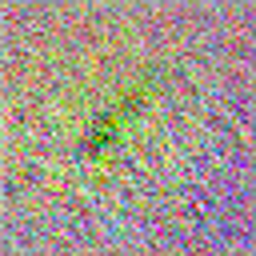

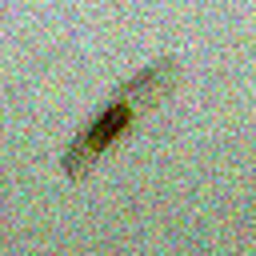

In [9]:
class MemoryModel(nn.Module):
    def __init__(self):
        super().__init__()
        nh, nx = cf.num_memory_h, cf.num_memory_x
        self.wf = nn.Conv2d(nh + nx, nh, 1)
        self.wh = nn.Conv2d(nh + nx, nh, 1)
    
    def forward(self, h, x):
        f = self.wf(torch.cat([h, x], dim=1)).sigmoid()
        h_til = self.wh(torch.cat([f * h, x], dim=1)).tanh()
        return (1 - f) * h + f * h_til

model = UNet2DModel(
    sample_size=cf.sample_size,
    # xt, local_emb, prev_frame_xt, mem_h
    in_channels=3 + 3 + 3 + cf.num_memory_h,
    # xt_noise, mem_x
    out_channels=3 + cf.num_memory_x,
    layers_per_block=cf.layers_per_block,
    block_out_channels=cf.block_out_channels,
    down_block_types=cf.down_block_types,
    up_block_types=cf.up_block_types
).to(cf.device)

memory_model = MemoryModel().to(cf.device)

noise_scheduler = DDIMScheduler(num_train_timesteps=cf.num_train_timesteps)

opt = torch.optim.AdamW(chain(
    model.parameters(), memory_model.parameters()
), lr=cf.lr)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=opt,
    num_warmup_steps=cf.num_warmup_steps,
    num_training_steps=cf.num_training_steps
)
loss_fn = nn.MSELoss()
losses = []

pool = Pool()

imgs, embs, memory = pool.sample(torch.tensor([0]))
x = torch.cat([imgs[:, 1], embs[:, 1], imgs[:, 0], memory], dim=1)
display.display(dataset.tensor_to_img(
    model(x, timestep=0)['sample'][0, :3]).resize((256, 256)))

noise = torch.randn_like(imgs[0, 1])
timesteps = torch.tensor([50], dtype=torch.long, device=cf.device)
noisy_image = noise_scheduler.add_noise(imgs[0, 1], noise, timesteps)
display.display(dataset.tensor_to_img(noisy_image).resize((256, 256)))

## Sampling

In [10]:
def get_pred_x0(x_t, t, pred_noise):
    alpha_prod_t = noise_scheduler.alphas_cumprod[t]
    beta_prod_t = 1 - alpha_prod_t
    return (x_t - beta_prod_t**.5 * pred_noise) / alpha_prod_t**.5

def gen_video(path, duration=2, fps=24, show_diffusion=False, memory_noise_level=0):
    tqdm._instances.clear()
    _training = model.training
    model.eval()
    memory_model.eval()
    
    def make_frame(frame_state):
        if frame_state['first_frame']:
            frame_state['first_frame'] = False
            return np.zeros((512, 512, 3), dtype=np.int8)
        
        with torch.no_grad():
            frame_imgs = torch.empty(4, 4, *cf.img_shape, device=cf.device)
            vis_id = 0
            
            xt = frame_state['noise'][:, :3]
            
            # reverse diffusion steps
            num_ts_train = noise_scheduler.num_train_timesteps
            num_ts_infer = len(cf.inference_timesteps)
            for i, t in enumerate(cf.inference_timesteps):
                if i == num_ts_infer - 1:
                    prev_t = -1
                else:
                    prev_t = cf.inference_timesteps[i + 1]
                noise_scheduler.set_timesteps(
                    num_inference_steps=num_ts_train // (t - prev_t))
                
                memory_noise_t = round(
                    (num_ts_train - 1) * np.clip(memory_noise_level, 0, 1))
                local_emb = dataset.embs[frame_state['local_emb_i']].to(cf.device)
                local_emb = resize(center_crop(
                    local_emb, round(cf.sample_size * 1.5)), cf.sample_size)
                prev_x0_noised = noise_scheduler.add_noise(
                    frame_state['prev_x0'], frame_state['noise'][:, 6:9], memory_noise_t
                )
                mem_noised = noise_scheduler.add_noise(
                    frame_state['memory'], frame_state['noise'][:, 9:], memory_noise_t
                )
                
                input_noised = torch.cat([xt, local_emb, prev_x0_noised, mem_noised], dim=1)
                pred = model(input_noised, t)['sample']
                
                if show_diffusion:
                    # show 4 of the diffusion steps
                    if i / (num_ts_infer - 1) >= (vis_id + 1) / 4 or i == num_ts_infer - 1:
                        pred_x0 = get_pred_x0(xt, t, pred[:, :3])
                        frame_imgs[:, vis_id] = dataset.denorm(pred_x0)
                        vis_id += 1
                elif i == num_ts_infer - 1:
                    frame_imgs = dataset.denorm(xt).view(4, 4, *cf.img_shape)
                
                xt = noise_scheduler.step(pred[:, :3], t, xt)['prev_sample']
            
            frame_state['prev_x0'] = xt
            # use memory from final prediction
            frame_state['memory'] = memory_model(frame_state['memory'], pred[:, 3:])
            # refresh noise
            frame_state['noise'] = torch.randn(frame_state['batch_size'],
                3 + 3 + 3 + cf.num_memory_h, *cf.img_shape[1:], device=cf.device)
            # get next local emb
            frame_state['local_emb_i'] = \
                (frame_state['local_emb_i'] + 1) % len(dataset.embs)
            
            frame = make_grid(
                frame_imgs.view(-1, *frame_imgs.shape[2:]), nrow=4)
            frame = resize(frame, 512).permute(1, 2, 0)
            return frame.clip(0, 1).multiply(255).int().cpu().numpy()
    
    if _training:
        model.train()
        memory_model.train()
    
    os.makedirs(os.path.dirname(path), exist_ok=True)
    batch_size = 4 if show_diffusion else 16
    frame_state = {
        'first_frame': True,
        'batch_size': batch_size,
        'prev_x0': torch.randn(batch_size, *cf.img_shape, device=cf.device),
        'memory': torch.randn(batch_size, cf.num_memory_h,
            *cf.img_shape[1:], device=cf.device),
        'noise': torch.randn(batch_size, 3 + 3 + 3 + cf.num_memory_h,
            *cf.img_shape[1:], device=cf.device),
        'local_emb_i': torch.randint(len(dataset.embs), (batch_size,))
    }
    clip = mpy.VideoClip(lambda t: make_frame(frame_state), duration=duration)
    clip.write_videofile(path, fps=fps)    
    return clip

## Training

Model ID: 946727614
50,000 / 50,000
14h20m - eta 1s
lr: 0.00000000
loss: 0.00357090


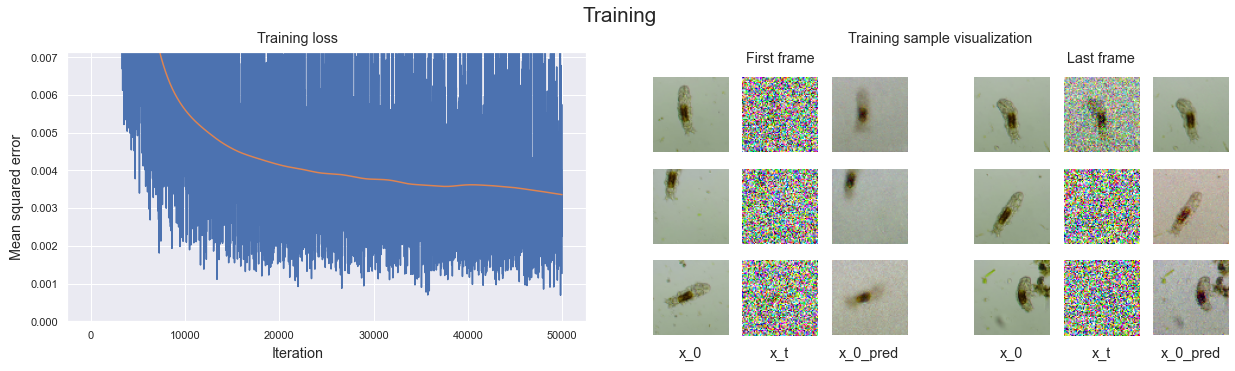

Moviepy - Building video models/VideoUNet_946727614/videos/step_50000.mp4.
Moviepy - Writing video models/VideoUNet_946727614/videos/step_50000.mp4



Moviepy - Done !
Moviepy - video ready models/VideoUNet_946727614/videos/step_50000.mp4
Generated video
Saved to models/VideoUNet_946727614


train/loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
train/step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss,0.00127
train/step,50000


In [11]:
def time_to_s(t):
    s = f'{int(t / 3600)}h' if t >= 3600 else ''
    s += f'{int(t / 60) % 60}m' if t >= 60 else ''
    s += f'{int(t) % 60}s' if t < 60 else ''
    return s

def train():
    while True:
        cf.model_id = f'{np.random.randint(1e9):09d}'
        model_path = f'models/VideoUNet_{cf.model_id}'
        if not os.path.exists(model_path):
            break
    
    model.train()
    memory_model.train()
    
    run = wandb.init(
        # mode='disabled',
        project='FractalDN',
        config=asdict(cf),
        save_code=True
    )
    wandb.define_metric('train/step')
    wandb.define_metric('train/*', step_metric='train/step')
    
    with run:
        print('Training...')
        train_st = time.time()
        
        for i in range(cf.num_training_steps):
            perm = torch.randperm(pool.size)[:cf.batch_size]
            x0, local_embs, memory = pool.sample(perm)
            
            prev_x0 = x0[:, 0]
            x0 = x0[:, 1:]
            local_embs = local_embs[:, 1:]
            
            xt_timesteps = torch.randint(
                noise_scheduler.num_train_timesteps,
                size=(cf.batch_size, cf.num_batch_frames),
                dtype=torch.long, device=cf.device
            )
            memory_timesteps = torch.randint_like(
                xt_timesteps, cf.num_memory_timesteps)
            noise = torch.randn(cf.batch_size, cf.num_batch_frames,
                3 + 3 + cf.num_memory_h, *cf.img_shape[1:], device=cf.device)
            
            loss = 0
            for frame_id in range(cf.num_batch_frames):
                xt = noise_scheduler.add_noise(x0[:, frame_id],
                    noise[:, frame_id, :3], xt_timesteps[:, frame_id])
                local_emb = local_embs[:, frame_id]
                prev_x0_memory_noised = noise_scheduler.add_noise(
                    torch.cat([prev_x0, memory], dim=1),
                    noise[:, frame_id, 3:], memory_timesteps[:, frame_id])
                model_input = torch.cat([
                    xt, local_emb, prev_x0_memory_noised], dim=1)
                
                pred = model(model_input, xt_timesteps[:, frame_id])['sample']
                loss = loss + loss_fn(pred[:, :3], noise[:, frame_id, :3])
                
                if frame_id == 0:
                    first_model_input = model_input
                    first_pred = pred
                
                prev_x0 = x0[:, frame_id]
                
                # compute memory from x0 with noised memory
                x0_input = torch.cat([
                    x0[:, frame_id], local_emb, prev_x0_memory_noised], dim=1)
                pred_0 = model(x0_input, timestep=0)['sample']
                memory = memory_model(memory, pred_0[:, 3:])
            
            loss = loss / cf.num_batch_frames
            
            # opt step
            opt.zero_grad()
            loss.backward()
            opt.step()
            lr_scheduler.step()
            
            # update pool
            pool.replace(perm, memory.detach().clone())
            
            # plot
            if (i + 1) % cf.loss_every_n == 0:
                losses.append(loss.item())
                wandb.log({
                    'train/step': i + 1,
                    'train/loss': loss.item()
                })
            
            if (i + 1) % cf.display_every_n == 0:                
                fig = plt.figure(constrained_layout=True, figsize=(5 * 3.4, 5))
                fig.suptitle('Training', fontsize='xx-large')
                loss_fig, vis_fig = fig.subfigures(1, 2, wspace=.1)
                
                loss_fig.suptitle('Training loss')
                loss_fig.supxlabel('Iteration')
                loss_fig.supylabel('Mean squared error')
                
                vis_fig.suptitle('Training sample visualization')
                
                ax = loss_fig.gca()
                loss_x = np.arange(len(losses)) * cf.loss_every_n
                loss_lowess = lowess(losses, loss_x, frac=.2)
                sns.lineplot(loss_x, losses, ax=ax)
                sns.lineplot(loss_lowess[:, 0], loss_lowess[:, 1])
                recent_avg_loss = np.mean(losses[-100:])
                if len(losses) > 0:
                    plt.ylim(0, recent_avg_loss * 2)
                
                vis_first, vis_last = vis_fig.subfigures(1, 2, wspace=.1)
                vis_first.suptitle('First frame')
                vis_last.suptitle('Last frame')
                
                last_model_input = model_input
                last_pred = pred
                num_replaced = round(cf.batch_size * cf.pool_replace_rate)
                for vis in [vis_first, vis_last]:                
                    vis_col_figs = vis.subfigures(1, 3)
                    x0_axes, xt_axes, x0p_axes = [
                        v.subplots(3, 1) for v in vis_col_figs]
                    for f, label in zip(vis_col_figs, ['x_0', 'x_t', 'x_0_pred']):
                        f.supxlabel(label)
                    
                    if vis == vis_first:
                        vis_frame = 0
                        model_input = first_model_input
                        pred = first_pred
                        t_sort = torch.argsort(xt_timesteps[:num_replaced, vis_frame])
                    else:
                        vis_frame = -1
                        model_input = last_model_input
                        pred = last_pred
                        t_sort = torch.argsort(
                            xt_timesteps[num_replaced:, vis_frame]) + num_replaced
                    
                    # show random samples of low, mid, high ranges of t
                    for k in range(3):
                        row_id = t_sort[np.random.randint(
                            t_sort.shape[0] // 3 * k,
                            t_sort.shape[0] // 3 * (k + 1))]
                        
                        x0_axes[k].imshow(dataset.tensor_to_img(x0[row_id, vis_frame]))
                        x0_axes[k].axis('off')
                        
                        xt_rgb = model_input[row_id, :3]
                        xt_axes[k].imshow(dataset.tensor_to_img(xt_rgb))
                        xt_axes[k].axis('off')
                        
                        t = xt_timesteps[row_id, vis_frame]
                        pred_x0 = get_pred_x0(xt_rgb, t, pred[row_id, :3])
                        x0p_axes[k].imshow(dataset.tensor_to_img(pred_x0))
                        x0p_axes[k].axis('off')
                
                display.clear_output(wait=True)
                print(f'Model ID: {cf.model_id}')
                print(f'{i + 1 :,} / {cf.num_training_steps:,}')
                time_passed = time.time() - train_st
                eta = time_passed * (cf.num_training_steps - i) / max(i, 1)
                print(f'{time_to_s(time_passed)} - eta {time_to_s(eta)}')
                print(f'lr: {opt.state_dict()["param_groups"][0]["lr"]:.8f}')
                print(f'loss: {recent_avg_loss:.8f}')
                plt.show()
            
            if (i + 1) % cf.video_every_n == 0:
                clip = gen_video(f'{model_path}/videos/step_{i + 1}.mp4')
                print('Generated video')
            
            if (i + 1) % cf.save_every_n == 0 or i == cf.num_training_steps - 1:
                model.save_pretrained(model_path)
                torch.save(memory_model, f'{model_path}/memory_model.pt')
                print(f'Saved to {model_path}')


if cf.load_pretrained:
    cf.model_id = cf.pretrained_path.split('_')[-1]
    model = model.from_pretrained(cf.pretrained_path).to(cf.device)
    memory_model = torch.load(f'{cf.pretrained_path}/memory_model.pt').to(cf.device)
    print(f'Loaded from {cf.pretrained_path}')
else:
    gc.collect()
    torch.cuda.empty_cache()
    tqdm._instances.clear()
    train()

## Sample from model

Moviepy - Building video output/VideoUNet_sample_946727614.mp4.
Moviepy - Writing video output/VideoUNet_sample_946727614.mp4



Moviepy - Done !
Moviepy - video ready output/VideoUNet_sample_946727614.mp4


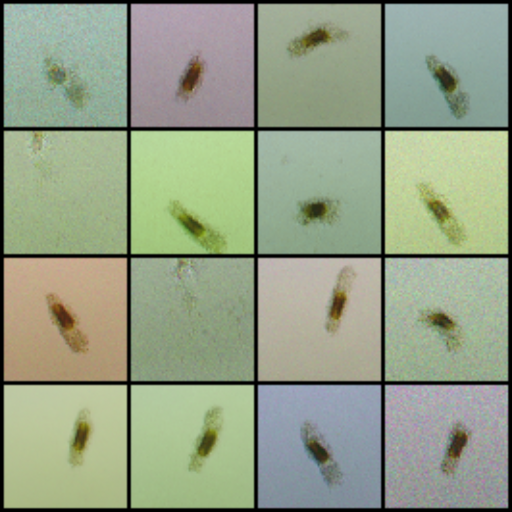

In [12]:
clip_name = f'VideoUNet_sample_{cf.model_id}'
clip = gen_video(f'output/{clip_name}.mp4', duration=5, memory_noise_level=0)
display_video(f'output/{clip_name}.mp4', loop=False)

display.display(Image.fromarray(
    clip.get_frame(2).astype(np.uint8)
).resize((512, 512)))